In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def ultimate_split(yb, input_data, ids):
    """
    The ultimate split. THE real BADA$$.
    This is some real shit
    """
    
    mask_0 = (input_data[:,22] == 0)
    mask_1 = (input_data[:,22] == 1)
    mask_2 = (input_data[:,22] == 2)
    mask_3 = (input_data[:,22] == 3)
    
    return yb[mask_0], yb[mask_1], yb[mask_2], yb[mask_3], \
input_data[mask_0], input_data[mask_1], input_data[mask_2], input_data[mask_3], \
ids[mask_0], ids[mask_1], ids[mask_2], ids[mask_3]

In [38]:
def remove_features_0(input_data_0):
    """
    Remove the useless features if the jet num feature is equal to 0
    """
    useless_features_index = [4, 5, 6, 12, 23, 24, 25 , 26, 27, 28, 30, 33]
    
    mask = np.ones(int(input_data_0.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return input_data_0[:,mask]

def remove_features_1(input_data_1):
    """
    Remove the useless features if the jet num feature is equal to 1
    """
    useless_features_index = [4, 5, 6, 26, 27, 28, 30, 33]
    
    mask = np.ones(int(input_data_1.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return input_data_1[:,mask]

    # No need for jet_num equal to 2 or 3 : all the features are kept    
    

In [39]:
def angle_features_processing(data_path):
    """
    We want to change all the features representing an angle into two features
    one for cosinus of the angle and another for sinus of the angle.
    """
    
    yb, input_data, ids = load_csv_data(data_path,sub_sample = False)

    angle_features = [15, 18, 20, 25, 28]
    
    new_data = np.zeros((input_data.shape[0], input_data.shape[1] + len(angle_features) ))
    
    for k in range(input_data.shape[1]):
        if k not in angle_features:
            new_data[:, k] = input_data[:, k]
        
    for idx, column in enumerate(angle_features): 
        
        new_data[:, column] = np.cos(input_data[:, column])
        new_data[:, input_data.shape[1] + idx] = np.sin(input_data[:, column])
    
    return yb, new_data, ids

In [49]:

yb, input_data, ids =  angle_features_processing("train.csv")
input_data = standardize(input_data)
yb0, yb1, yb2, yb3, data0, data1, data2, data3, ids0, ids1, ids2, ids3 = ultimate_split(yb, input_data, ids)

data0 = remove_features_0(data0)
data1 = remove_features_1(data1)
print np.shape(data0), np.shape(data1), np.shape(data2)


(0L, 23L) (0L, 27L) (0L, 35L)


In [36]:
np.std(data0)

0.9999999999999987

In [40]:
def jet_num_split_alt(yb, input_data, ids):
    """ jet_num is feature number 22 (starting counting at 0)
    returns 1) the data with jet_num <= 1 and 2) the data with jet_num >1
    4 5 6 23 24 25 26 27"""
    bool_mask = (input_data[:,22]<=1)

    return yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]

def remove_useless_features_alt(input_data_jetnum_inf1):
    useless_features_index = [4,5,6,23,24,25,26,27,28, 30, 33]
    mask = np.ones(int(input_data_jetnum_inf1.shape[1]), dtype=bool)
    # print(mask.shape)
    mask[(useless_features_index)] = False
    return input_data_jetnum_inf1[:,mask]

In [41]:
def jet_num_split(data_path, sub_sample = False):
    """ jet_num is feature number 22 (starting counting at 0)
        returns 1) the data with jet_num <= 1 and 2) the data with jet_num >1
        4 5 6 23 24 25 26 27"""
    yb, input_data, ids = load_csv_data(data_path,sub_sample = False)
    bool_mask = (input_data[:,22]<=1)

    return yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]

def remove_useless_features(input_data_jetnum_inf1):
    useless_features_index = [4,5,6,23,24,25,26,27,28]
    mask = np.ones(int(input_data_jetnum_inf1.shape[1]), dtype=bool)
    # print(mask.shape)
    mask[(useless_features_index)] = False
    return input_data_jetnum_inf1[:,mask]

In [ ]:
""" OLD """
yb, input_data, ids =  angle_features_processing("train.csv")

yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1 = jet_num_split_alt(yb, input_data, ids)

input_data_inf1 = remove_useless_features_alt(input_data_inf1)

In [49]:
""" OLD """
yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1 = jet_num_split("train.csv", sub_sample = False)
input_data_inf1 = remove_useless_features(input_data_inf1)

In [19]:
print(input_data_inf1.shape)
print(input_data_sup1.shape)

(177457, 24)
(72543, 35)


In [42]:
def ridge(yb_test, input_data_test, yb_train, input_data_train,lambda_):
    w, train_loss = ridge_regression(yb_train, input_data_train, lambda_)
    
    #w, train_loss = least_squares_GD_adapt_step(yb_train, input_data_train, 0*np.random.rand(int(input_data_train.shape[1])), 1000, 0.00000000001,computeLoss = True);
    
    test_loss = compute_loss(yb_test, input_data_test, w)
    y_pred = predict_labels(w, input_data_test)
    return w, train_loss, test_loss, y_pred


In [43]:
""" Générateur renvoyant (en k fois) des données splitées pour train et test
    Retourne les données de train puis de test"""
def K_split_LS(yb,input_data,ids,k):
    n = int(yb.shape[0])
    bool_mask = np.ones(n,dtype=bool)
    bool_mask[::k] = 0
    """On renvoie ... train puis ... test"""
    for i in range(k):
        yield yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]
        bool_mask[i::k] = 1
        bool_mask[i+1::k] = 0

In [44]:
def Kfold_ridge(k,degree,lambda_):

    train_loss_list = []
    test_loss_list = []
    score_list = []
    for yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test in K_split_LS(yb3, data3, ids3,k):
        input_data_train_poly = build_poly(input_data_train,degree)
        input_data_test_poly = build_poly(input_data_test,degree)
        w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)
        train_loss_list+=[train_loss]
        test_loss_list+=[test_loss]
        score_list+=[np.mean(y_pred == yb_test)]
        
    return train_loss_list, test_loss_list,score_list  

In [45]:
def CrossVal_ridge(k,degree,lambda_):

    yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test = data_spliting(yb, input_data, ids)
    
    input_data_train_poly = build_poly(input_data_train,degree)
    input_data_test_poly = build_poly(input_data_test,degree)
    
    w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)

        
    return [train_loss], [test_loss], [np.mean(y_pred == yb_test)]

In [46]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


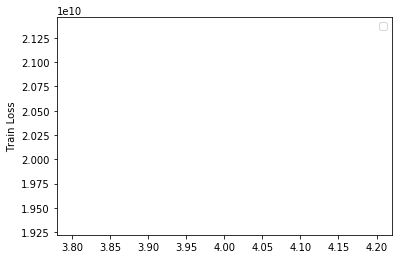

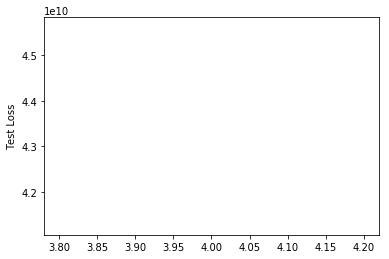

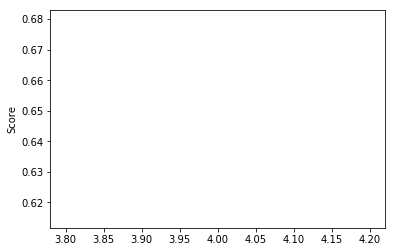

([20342025855.44099], [43446135746.815994], [0.6472654895140766])

In [21]:
def param_test(k,max_deg,max_lambda,lambda_step):
    #lambda_list = np.arange(10,max_lambda,lambda_step)
    #lambda_list = np.sort(2000*(1+np.random.rand(10)))
    lambda_list = np.logspace(-5, 0, num=10)
    degree_list = np.arange(4,max_deg)
    final_train_loss_list = []
    final_test_loss_list = []
    final_score_list = []
    
    lambda_ = 10
    
    for degree in degree_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss]
        final_test_loss_list+=[test_loss]
        final_score_list+=[score]
        print("Degree " + str(degree) + " done")
    """
    degree = 9
    for lambda_ in lambda_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss]
        final_test_loss_list+=[test_loss]
        final_score_list+=[score]
        print("Lambda =  " + str(lambda_) + " done")
    """
    plt.legend()
    plt.figure(1)  
    plt.plot(degree_list,final_train_loss_list)
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.plot(degree_list,final_test_loss_list)
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.plot(degree_list,final_score_list)
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list


def param_test_simultane(k,max_deg,max_lambda,number_lambda):
    lambda_list = np.linspace(10,max_lambda,number_lambda)
    #lambda_list = np.logspace(1, 5, num=5)
    degree_list = np.arange(2,max_deg+1)
    
    final_train_loss_list = np.zeros((len(degree_list),number_lambda))
    final_test_loss_list = np.zeros((len(degree_list),number_lambda))
    final_score_list = np.zeros((len(degree_list),number_lambda))
    """
    final_train_loss_list = np.zeros((len(degree_list),5))
    final_test_loss_list = np.zeros((len(degree_list),5))
    final_score_list = np.zeros((len(degree_list),5))
    """
    
    for j,degree in enumerate(degree_list):
        for i, lambda_ in enumerate(lambda_list):
            train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
            #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
            train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
            final_train_loss_list[j,i]=train_loss
            final_test_loss_list[j,i]=test_loss
            final_score_list[j,i]=score
            print ("Degree = " + str(degree) + " and Lambda = " + str(lambda_))
    
    
    plt.legend()
    plt.figure(1)
    #plt.contourf(lambda_list,degree_list, final_train_loss_list, 20, cmap='RdGy')
    plt.pcolor(lambda_list,degree_list, final_train_loss_list)
    #plt.colorbar();
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.contourf(lambda_list,degree_list,  final_test_loss_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.contourf(lambda_list,degree_list,  final_score_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list

param_test(10,5,100,10)


In [59]:
def submission_ridge(degree_inf1,degree_sup1,lambda_inf1,lambda_sup1):
    
    #For the inf1 data
    # yb_inf1_test, input_data_inf1_test, ids_inf1_test, yb_sup1_test, input_data_sup1_test, ids_sup1_test = jet_num_split("test.csv")
    yb_t, input_data_t, ids_t =  angle_features_processing("test.csv")

    yb_inf1_test, input_data_inf1_test, ids_inf1_test, yb_sup1_test, input_data_sup1_test, ids_sup1_test = jet_num_split_alt(yb_t, input_data_t, ids_t)

    input_data_inf1_test = remove_useless_features_alt(input_data_inf1_test)
    
    
    
    input_data_inf1_test_poly = build_poly(input_data_inf1_test, degree_inf1)
    input_data_inf1_poly = build_poly(input_data_inf1,degree_inf1)
    w, train_loss, test_loss, y_pred_inf1 = ridge(yb_inf1_test, input_data_inf1_test_poly, yb_inf1, input_data_inf1_poly,lambda_inf1)
    
    #For the sup1 data
    input_data_sup1_test_poly = build_poly(input_data_sup1_test, degree_sup1)
    input_data_sup1_poly = build_poly(input_data_sup1,degree_sup1)
    w, train_loss, test_loss, y_pred_sup1 = ridge(yb_sup1_test, input_data_sup1_test_poly, yb_sup1, input_data_sup1_poly,lambda_sup1)
    
    final_ids_test = np.concatenate((ids_inf1_test,ids_sup1_test))
    final_y_pred = np.concatenate((y_pred_inf1,y_pred_sup1))
    create_csv_submission(final_ids_test, final_y_pred, "pred_4_210.csv")
    
submission_ridge(8,10,150,120)    

NameError: global name 'input_data_inf1' is not defined

In [ ]:
def submission_ridge_4split(deg0, deg1, deg2, deg3,lambda0, lambda1, lambda2, lambda3):
    
    #For the jet_num 0 data
    yb_t, input_data_t, ids_t =  angle_features_processing("test.csv")
    input_data_t = standardize(input_data_t)
    yb0t, yb1t, yb2t, yb3t, data0t, data1t, data2t, data3t, ids0t, ids1t, ids2t, ids3t = ultimate_split(yb_t, input_data_t, ids_t)

    data0t = remove_features_0(data0t)
    data1t = remove_features_1(data1t)
    
        
    poly_test0 = build_poly(data0t, deg0)

    poly0 = build_poly(data0,deg0)
    w, train_loss, test_loss, y_pred0 = ridge(yb0t, poly_test0, yb0, poly0,lambda0)
    
    #For the jet_num 1 data
    poly_test1 = build_poly(data1t, deg1)
    poly1 = build_poly(data1,deg1)
    w, train_loss, test_loss, y_pred1 = ridge(yb1t, poly_test1, yb1, poly1,lambda1)
    
    #For the jet_num 2 data
    poly_test2 = build_poly(data2t, deg2)
    poly2 = build_poly(data2,deg2)
    w, train_loss, test_loss, y_pred2 = ridge(yb2t, poly_test2, yb2, poly2,lambda2)

    #For the jet_num 3 data
    poly_test3 = build_poly(data3t, deg3)
    poly3 = build_poly(data3,deg3)
    w, train_loss, test_loss, y_pred3 = ridge(yb3t, poly_test3, yb3, poly3,lambda3)

    
    
    final_ids_test = np.concatenate((ids0t, ids1t, ids2t, ids3t))
    final_y_pred = np.concatenate((y_pred0,y_pred1,y_pred2,y_pred3))
    create_csv_submission(final_ids_test, final_y_pred, "pred_4split.csv")
    
submission_ridge_4split(7,8,8,9,10,10,10,10)    

In [23]:
"""yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1"""
#w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test, yb, input_data,0)
w, train_loss = least_squares_GD(yb, input_data, np.random.rand(int(input_data.shape[1])), 100, 0.00000001,computeLoss = True);

250000
[ 2.85456619e+05 -8.52566139e+04 -1.15462623e+05 -1.11235678e+04
  1.72510086e+06  1.84662910e+06  1.72414230e+06 -3.84918127e+03
 -1.55412291e+04 -7.30000083e+04 -1.98331392e+03  1.17813248e+03
  1.72454673e+06 -4.55668042e+04  2.99605524e+01  2.51387887e+00
 -5.77838357e+04  5.87600409e+01  1.51479330e+00 -4.04844843e+04
 -3.64679398e+00 -1.44028727e+05  1.16997337e+02  1.17171261e+06
  1.16772391e+06 -1.16484234e+03  1.74341139e+06  1.72441225e+06
 -1.72654885e+03  3.03506326e+04  1.65644212e+01 -3.62399258e+01
  1.67378394e+01 -2.81097293e+01 -4.69259330e+01]
250000
[ 2.76383718e+05 -8.07973060e+04 -1.08765020e+05 -8.59514414e+03
  1.64115554e+06  1.76089385e+06  1.64021373e+06 -3.64068130e+03
 -1.43568755e+04 -6.49759987e+04 -1.86815470e+03  1.13673321e+03
  1.64060873e+06 -4.26830246e+04  2.86375908e+01  2.39701430e+00
 -5.42144171e+04  5.62829304e+01  1.47365007e+00 -3.77052123e+04
 -3.45755281e+00 -1.31848209e+05  1.43822692e+02  1.12196093e+06
  1.11618918e+06 -1.113412

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150

250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.03115091e+03  1.52487955e+06  1.50631309e+06
 -1.50827921e+03  3.44186017e+04  1.44083332e+01 -3.11689137e+01
  1.50574470e+01 -2.52779756e+01 -4.11307820e+01]
250000
[ 2.61850349e+05 -7.36698691e+04 -9.80635065e+04 -4.56288988e+03
  1.50697852e+06  1.62383571e+06  1.50606365e+06 -3.30748816e+03
 -1.24653942e+04 -5.21695943e+04 -1.68415288e+03  1.07045446e+03
  1.50644350e+06 -3.80762563e+04  2.65219359e+01  2.21009015e+00
 -4.85119386e+04  5.23201624e+01  1.40752269e+00 -3.32658916e+04
 -3.15500187e+00 -1.12400983e+05  1.86543780e+02  1.04237298e+06
  1.03376095e+06 -1.031150